# Root finding methods

In [1]:
# Import JAX for math stuff and automatic differentiation
import jax
import jax.numpy as jnp
from jax import config

config.update(
    "jax_enable_x64", True
)  # JAX uses single precision numbers by default, here we change that to double precision

# Import matplotlib and niceplots for plotting
import matplotlib.pyplot as plt
import niceplots

Root finding methods are used to find the roots of a function, that is they find the value(s) of $x$ that make $f(x)=0$. This notebook contains some simple code that implements two simple 1D root finding methods for scalar functions.

## Bisection

In the bisection method, we start with two points, $a$ and $b$ such that $f(a)$ and $f(b)$ have opposite signs. If this is the case (and we know $f$ is continuous) then we know there must be a root between $a$ and $b$.
We start the bisection method by setting $a$ and $b$ as our lower and upper bounds $x_L, x_U$ of our search space. Then, each iteration, we evaluate $f$ at the midpoint of the space $x_M = 1/2(x_L + x_U)$. Depending on the sign of $f(x_M)$, we set either $x_L$ or $x_U$ to $x_M$ to half the size of our search space. This is repeated until $f(x_M)$ is as close to zero as we need.

The code below contains a function that implements the bisection method.

In [2]:
def bisection(f, a, b, tol=1e-6, max_iterations=100):
    # First, check that a and b do actually bracket a root
    fa = f(a)
    fb = f(b)
    f_history = []

    if fa * fb > 0:
        raise ValueError("Initial interval does not bracket a root.")

    for i in range(max_iterations):
        c = (a + b) / 2
        fc = f(c)
        f_history.append(abs(float(fc)))

        print(f"Iteration {i:02d}: x = {c: 7.3e}, f(x) = {fc: 7.3e}")

        if jnp.abs(fc) < tol:
            return c, f_history

        if fa * fc < 0:
            b = c
            fb = fc
        else:
            a = c
            fa = fc

    return None, f_history  # Return None as the root if the root was not found within max_iterations

Now let's try it out on a simple function, $f(x) = e^x - 1$, which has a root at $x=0$.

In [3]:
# Define the function to find the root of f = e^x - 1,
def func(x):
    return jnp.exp(x) - 1


# Initial interval
a = -1
b = 2

root, bisect_history = bisection(func, a, b)
if root is not None:
    print("Root found:", root)
else:
    print("Root not found within max_iterations")

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


Iteration 00: x =  5.000e-01, f(x) =  6.487e-01
Iteration 01: x = -2.500e-01, f(x) = -2.212e-01
Iteration 02: x =  1.250e-01, f(x) =  1.331e-01
Iteration 03: x = -6.250e-02, f(x) = -6.059e-02
Iteration 04: x =  3.125e-02, f(x) =  3.174e-02
Iteration 05: x = -1.562e-02, f(x) = -1.550e-02
Iteration 06: x =  7.812e-03, f(x) =  7.843e-03
Iteration 07: x = -3.906e-03, f(x) = -3.899e-03
Iteration 08: x =  1.953e-03, f(x) =  1.955e-03
Iteration 09: x = -9.766e-04, f(x) = -9.761e-04
Iteration 10: x =  4.883e-04, f(x) =  4.884e-04
Iteration 11: x = -2.441e-04, f(x) = -2.441e-04
Iteration 12: x =  1.221e-04, f(x) =  1.221e-04
Iteration 13: x = -6.104e-05, f(x) = -6.103e-05
Iteration 14: x =  3.052e-05, f(x) =  3.052e-05
Iteration 15: x = -1.526e-05, f(x) = -1.526e-05
Iteration 16: x =  7.629e-06, f(x) =  7.629e-06
Iteration 17: x = -3.815e-06, f(x) = -3.815e-06
Iteration 18: x =  1.907e-06, f(x) =  1.907e-06
Iteration 19: x = -9.537e-07, f(x) = -9.537e-07
Root found: -9.5367431640625e-07


## Newton-Raphson method

The Newton-Raphson (or even [Newton-Raphson-Simpson](https://en.wikipedia.org/wiki/Newton%27s_method#History)) method can accelerate the root finding process by not just using $f(x)$ but also it's derivative $\frac{df}{dx}$.

The method starts with an initial guess $x = x_0$, where $f(x_0) \neq 0$. Using the derivative, we can write a linear approximation of $f$ that is accurate near $x$:

$$f(x) \approx f(x_0) + (x - x_0) \frac{df}{dx}$$

As long as $df/dx \neq 0$, this linear approximation of $f$ is guaranteed to have a root, which we can use as our next guess $x_1$:

$$x_1 = x_0 - \frac{f(x_0)}{df/dx}$$

Again, this process is repeated until $f(x_n)$ is as close to zero as we need.

The code below implements the Newton-Raphson method and then uses it to find the same root we did above. Note that in this example we use JAX to automatically calculate $df/dx$ for us so we don't have to do any manual differentiation.

In [4]:
def newton_raphson(f, x0, tol=1e-6, max_iterations=100):
    x = x0
    f_history = []
    for i in range(max_iterations):
        f_val = f(x)
        f_history.append(abs(float(f_val)))
        print(f"Iteration {i:02d}: x = {x: 7.3e}, f(x) = {f_val: 7.3e}")

        # If f(x) is close enough to zero, we are done
        if jnp.abs(f_val) < tol:
            return x_new, f_history
        f_prime_val = jax.grad(f)(x)

        # Otherwise, take a Newton-Raphson step
        x_new = x - f_val / f_prime_val
        x = x_new

    return None, f_history  # Return None if the root was not found within max_iterations


# Initial guess
x0 = 1.0

root, newton_history = newton_raphson(func, x0)
if root is not None:
    print("Root found:", root)
else:
    print("Root not found within max_iterations")

Iteration 00: x =  1.000e+00, f(x) =  1.718e+00
Iteration 01: x =  3.679e-01, f(x) =  4.447e-01
Iteration 02: x =  6.008e-02, f(x) =  6.192e-02
Iteration 03: x =  1.769e-03, f(x) =  1.771e-03
Iteration 04: x =  1.564e-06, f(x) =  1.564e-06
Iteration 05: x =  1.223e-12, f(x) =  1.223e-12
Root found: 1.2233215659894107e-12


Now let's plot the value of $f(x)$ from the iterations of each method to see how quickly they converge to the root.

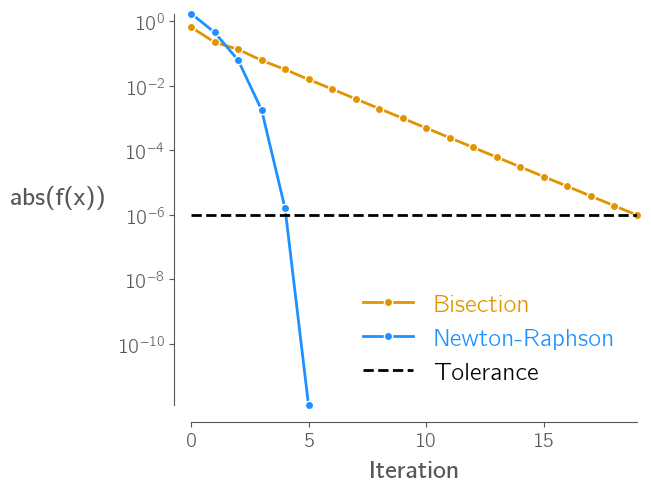

In [5]:
plt.style.use(niceplots.get_style())

fig, ax = plt.subplots()
ax.set_xlabel("Iteration")
ax.set_ylabel("abs(f(x))", rotation="horizontal", ha="right")

# Convergence plots like this look better when the y-axis is logarithmic
ax.set_yscale("log")

ax.plot(bisect_history, "-o", label="Bisection", clip_on=False)
ax.plot(newton_history, "-o", label="Newton-Raphson", clip_on=False)

# Plot a horizontal line at the tolerance
ax.axhline(1e-6, color="k", linestyle="--", label="Tolerance")
ax.legend(labelcolor="linecolor")
niceplots.adjust_spines(ax)
plt.show()

The Newton-Raphson method found the root in far fewer iterations than the Bisection method, even though it's first guess was further from the root. Additionally, we didn't have to find the initial bounds for the search space, which can be difficult in general. Some of the disadvantages of the Newton-Raphson method are

- It requires the derivative of $f$ to be known, which can be difficult to calculate.
- It' not guaranteed to converge, depending on the initial guess and the behaviour of $f$ it can even diverge! See the "What can go wrong" section on [this page](https://amsi.org.au/ESA_Senior_Years/SeniorTopic3/3j/3j_2content_2.html) for some examples.

## Multidimensional Newton-Raphson

Another advantage of Newton-Raphson is that it can be extended to multidimensional root finding problems. In this case, a few small changes are made:

1. We typically replace $x$ and $f$ with the state vector $\mathbf{u}$ and the residual vector $\mathbf{r}$. Both are vectors of length $N$ (or in math-speak $\mathbf{u}, \mathbf{r} \in \mathbb{R}^N$) and we are looking for the values of $\mathbf{u}$ that make all the entries in $\mathbf{r}$ zero. A good example might be a CFD solver, where the state is the vector of the velocities/pressures/temperatures in all the cells, and the residual is a measure of the error in the discretised flow equations in each cell.
2. $\mathbf{dr/du}$ is now an $N \times N$ matrix ($\mathbf{dr/du} \in \mathbb{R}^{N \times N}$) and we can't divide by a matrix. So the equation for updating the state becomes $\mathbf{u_{i+1}} = \mathbf{u_i} - \mathbf{dr/du}^{-1}\mathbf{r(u_i)}$ [^ref]
3. Since we are now dealing with multiple values that we want all to be (close to) zero, we need a way to measure how close we are to the root. We can do this using the norm of the residual vector, different types of vector norms are covered in section 1.3 of the course notes

More details on the multi-dimensional Newton-Raphson method can be found in section 1.7 of the course notes.


[^ref]: Whenever you see an equation in the form $\mathbf{x} = \mathbf{A}^{-1}\mathbf{b}$, where $\mathbf{A}$ is a big matrix, you should know that in practice you shouldn't actually compute the inverse of $\mathbf{A}$! Instead, you should use a linear solution method (some of which are covered in this course) to solve the equation $\mathbf{A}\mathbf{x} = \mathbf{b}$ for the $\mathbf{x}$ vector.